In [1]:
# imports
import tensorflow.keras as keras


2023-06-27 17:20:13.064550: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 17:20:13.188106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-27 17:20:13.188256: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Task 0
def autoencoder(input_dims, hidden_layers, latent_dims):
    """
    Creates a vanilla autoencoder

    Args:
        input_dims - integer containing the dimensions of the model input
        hidden_layers - list containing the number of nodes for each hidden
            layer in the encoder, respectively
        latent_dims - integer containing the dimensions of the latent space
            representation

    Returns:
        encoder - the encoder model
        decoder - the decoder model
        auto - the full autoencoder model
    """

    # First, build the encoder
    input_img = keras.Input(shape=(input_dims,))
    # print(input_img.shape)
    encoded = input_img
    for layer in hidden_layers:
        encoded = keras.layers.Dense(layer, activation='relu')(encoded)
    encoded = keras.layers.Dense(latent_dims, activation='relu')(encoded)
    encoder = keras.Model(input_img, encoded, name='encoder')

    # Now, build the decoder
    decoder_img = keras.Input(shape=(latent_dims,))
    decoded = decoder_img
    for layer in hidden_layers[::-1]:
        decoded = keras.layers.Dense(layer, activation='relu')(decoded)
    decoded = keras.layers.Dense(input_dims, activation='sigmoid')(decoded)
    decoder = keras.Model(decoder_img, decoded, name='decoder')

    # Let's put it all together
    # autoencoder_input = keras.Input(shape=(input_dims,))
    encoded_output = encoder(input_img)
    # print(input_img.shape)
    decoded_output = decoder(encoded_output)
    autoencoder = keras.Model(input_img,
                              decoded_output,
                              name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return encoder, decoder, autoencoder


2023-06-27 17:20:37.466793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-27 17:20:37.466980: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-27 17:20:37.467191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BensLaptop): /proc/driver/nvidia/version does not exist
2023-06-27 17:20:37.468943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
235/235 [==============================] - 4s 14ms/step - loss: 0.2415 - val_loss: 0.1669
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1517 - val_loss: 0.1383
Epoch 3/50
235/235 [==============================] - 5s 21ms/step - loss: 0.1338 - val_loss: 0.1269
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1244 - val_loss: 0.1186
Epoch 5/50
235/235 [==============================] - 4s 16ms/step - loss: 0.1176 - val_loss: 0.1132
Epoch 6/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1129 - val_loss: 0.1096
Epoch 7/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1098 - val_loss: 0.1073
Epoch 8/50
235/235 [==============================] - 4s 15ms/step - loss: 0.1071 - val_loss: 0.1045
Epoch 9/50
235/235 [==============================] - 5s 20ms/step - loss: 0.1048 - val_loss: 0.1025
Epoch 10/50
235/235 [==============================] - 3s 15ms/step - loss: 0.1029 - val_lo

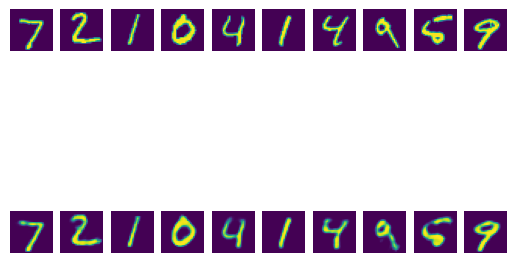

In [3]:
# 0-main
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.keras.datasets import mnist

# autoencoder = __import__('0-vanilla').autoencoder

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
np.random.seed(0)
tf.set_random_seed(0)
encoder, decoder, auto = autoencoder(784, [128, 64], 32)
auto.fit(x_train, x_train, epochs=50,batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))
encoded = encoder.predict(x_test[:10])
print(np.mean(encoded))
reconstructed = decoder.predict(encoded)

for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    ax.axis('off')
    plt.imshow(x_test[i].reshape((28, 28)))
    ax = plt.subplot(2, 10, i + 11)
    ax.axis('off')
    plt.imshow(reconstructed[i].reshape((28, 28)))
plt.show()

In [4]:
# Task 1 - Sparse autoencoder
# Add a lambtha, to be used as the L1 paramater for regularization

def autoencoder(input_dims, hidden_layers, latent_dims, lambtha):
    """
    Creates a sparse autoencoder

        Args:
        input_dims - integer containing the dimensions of the model input
        hidden_layers - list containing the number of nodes for each hidden
            layer in the encoder, respectively
        latent_dims - integer containing the dimensions of the latent space
            representation
        lambtha - regularization paramater used for L1 regularization on the
            encoded output

    Returns:
        encoder - the encoder model
        decoder - the decoder model
        auto - the full autoencoder model
    """

    # Create reg variable to keep line length short
    reg = keras.regularizers.l1(lambtha)

    # First, build the encoder
    input_img = keras.Input(shape=(input_dims,))
    encoded = input_img
    for layer in hidden_layers:
        encoded = keras.layers.Dense(layer,
                                     activation='relu'
                                     )(encoded)
    encoded = keras.layers.Dense(latent_dims,
                                 activation='relu',
                                 activity_regularizer=reg
                                 )(encoded)
    encoder = keras.Model(input_img, encoded, name='encoder')

    # Now, build the decoder
    decoder_img = keras.Input(shape=(latent_dims,))
    decoded = decoder_img
    for layer in hidden_layers[::-1]:
        decoded = keras.layers.Dense(layer, activation='relu')(decoded)
    decoded = keras.layers.Dense(input_dims, activation='sigmoid')(decoded)
    decoder = keras.Model(decoder_img, decoded, name='decoder')

    # Let's put it all together
    encoded_output = encoder(input_img)
    decoded_output = decoder(encoded_output)
    autoencoder = keras.Model(input_img,
                              decoded_output,
                              name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return encoder, decoder, autoencoder

Epoch 1/100
235/235 [==============================] - 5s 17ms/step - loss: 0.2426 - val_loss: 0.1677
Epoch 2/100
235/235 [==============================] - 3s 12ms/step - loss: 0.1529 - val_loss: 0.1395
Epoch 3/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1330 - val_loss: 0.1258
Epoch 4/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1229 - val_loss: 0.1177
Epoch 5/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1172 - val_loss: 0.1140
Epoch 6/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1137 - val_loss: 0.1104
Epoch 7/100
235/235 [==============================] - 5s 22ms/step - loss: 0.1106 - val_loss: 0.1079
Epoch 8/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1078 - val_loss: 0.1053
Epoch 9/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1056 - val_loss: 0.1033
Epoch 10/100
235/235 [==============================] - 4s 18ms/step - loss: 0.103

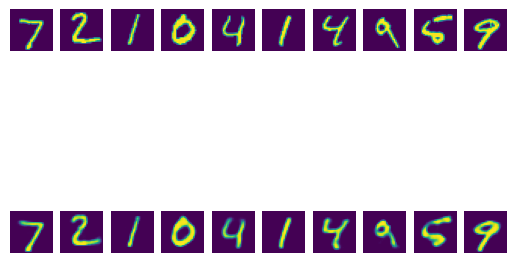

In [5]:
# 1-main

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.keras.datasets import mnist

# autoencoder = __import__('1-sparse').autoencoder

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
np.random.seed(0)
tf.set_random_seed(0)
encoder, decoder, auto = autoencoder(784, [128, 64], 32, 10e-6)
auto.fit(x_train, x_train, epochs=100,batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))
encoded = encoder.predict(x_test[:10])
print(np.mean(encoded))
reconstructed = decoder.predict(encoded)

for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    ax.axis('off')
    plt.imshow(x_test[i].reshape((28, 28)))
    ax = plt.subplot(2, 10, i + 11)
    ax.axis('off')
    plt.imshow(reconstructed[i].reshape((28, 28)))
plt.show()

In [6]:
# Convolutional Autoencoder
def autoencoder(input_dims, filters, latent_dims):
    """
    Create a convolutional autoencoder

    Each convolution in the encoder and decoder should use a kernel size of
        (3, 3) with same padding and relu activation followed by max pooling
        size of (2, 2)

    Args:
        input_dims - tuple of integers containing the dimensions of the input
        filters - list containing the number of filters for each convolutional
            layer in the encoder, respectively
        The filters should be reversed for the decoder
        latent_dims - tuple of integers containing the dimensions of the latent
            space representation

    Returns:
        encoder - the encoder model
        decoder - the decoder model
        auto - the full autoencoder model
    """
    # i = 0
    # Build the encoder
    input_img = keras.Input(shape=input_dims)
    encoded = input_img
    for filter in filters:
        encoded = keras.layers.Conv2D(filter,
                                      (3, 3),
                                      activation='relu',
                                      padding='same')(encoded)
        encoded = keras.layers.MaxPooling2D((2, 2),
                                            padding='same')(encoded)
    encoder = keras.Model(input_img, encoded, name='encoder')

    # Build the decoder
    decoder_img = keras.Input(shape=latent_dims)
    decoded = decoder_img
    # print(filters[0])
    # print(filters[1])
    # print(filters[2])
    # Loop through filters backwards
    # for filter in filters[1::-1]:
    #     print("loop: " + str(i))
    #     print(filter)
    #     i += 1
    #     decoded = keras.layers.Conv2D(filter - 1,
    #                                   (3, 3),
    #                                   activation='relu',
    #                                   padding='same')(decoded)
    #     decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    # print(filters[0])
    # Going to try to manually loop
    decoded = keras.layers.Conv2D(filters[2],
                                  (3, 3),
                                  activation='relu',
                                  padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    
    decoded = keras.layers.Conv2D(filters[1],
                                  (3, 3),
                                  activation='relu',
                                  padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)

    decoded = keras.layers.Conv2D(filters[0],
                                  (3, 3),
                                  activation='relu',
                                  padding='valid')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    # print("Exited loop")
    decoded = keras.layers.Conv2D(1,
                                  (3, 3),
                                  activation='sigmoid',
                                  padding='same')(decoded)
    decoder = keras.Model(decoder_img,
                          decoded,
                          name='decoder')

    # Bring it all together
    encoded_output = encoder(input_img)
    decoded_output = decoder(encoded_output)
    autoencoder = keras.Model(input_img,
                              decoded_output,
                              name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return encoder, decoder, autoencoder

(60000, 28, 28, 1)
(10000, 28, 28, 1)
Epoch 1/50
235/235 [==============================] - 18s 72ms/step - loss: 0.2712 - val_loss: 0.1627
Epoch 2/50
235/235 [==============================] - 20s 83ms/step - loss: 0.1487 - val_loss: 0.1379
Epoch 3/50
235/235 [==============================] - 19s 83ms/step - loss: 0.1317 - val_loss: 0.1263
Epoch 4/50
235/235 [==============================] - 16s 70ms/step - loss: 0.1232 - val_loss: 0.1192
Epoch 5/50
235/235 [==============================] - 20s 85ms/step - loss: 0.1182 - val_loss: 0.1150
Epoch 6/50
235/235 [==============================] - 19s 82ms/step - loss: 0.1147 - val_loss: 0.1123
Epoch 7/50
235/235 [==============================] - 20s 84ms/step - loss: 0.1125 - val_loss: 0.1103
Epoch 8/50
235/235 [==============================] - 18s 77ms/step - loss: 0.1105 - val_loss: 0.1089
Epoch 9/50
235/235 [==============================] - 20s 85ms/step - loss: 0.1090 - val_loss: 0.1072
Epoch 10/50
235/235 [=======================

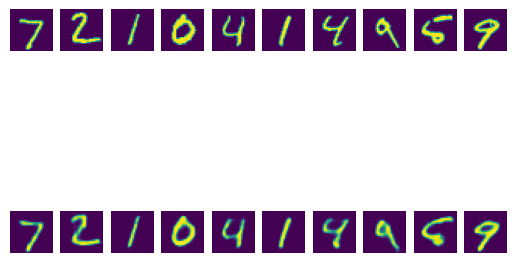

In [7]:
# 2-main
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.keras.datasets import mnist

# autoencoder = __import__('2-convolutional').autoencoder

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape)
print(x_test.shape)
np.random.seed(0)
tf.set_random_seed(0)
encoder, decoder, auto = autoencoder((28, 28, 1), [16, 8, 8], (4, 4, 8))
auto.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))
encoded = encoder.predict(x_test[:10])
print(np.mean(encoded))
reconstructed = decoder.predict(encoded)[:,:,:,0]

for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    ax.axis('off')
    plt.imshow(x_test[i,:,:,0])
    ax = plt.subplot(2, 10, i + 11)
    ax.axis('off')
    plt.imshow(reconstructed[i])
plt.show()